In [266]:
# Importing libraries
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from PIL import Image
import numpy as np

In [267]:
# Load the dataset
dataset = pd.read_csv('datasets/pokemon.csv')
print(f'Dataset shape: {dataset.shape}')
dataset.head()

Dataset shape: (801, 41)


,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


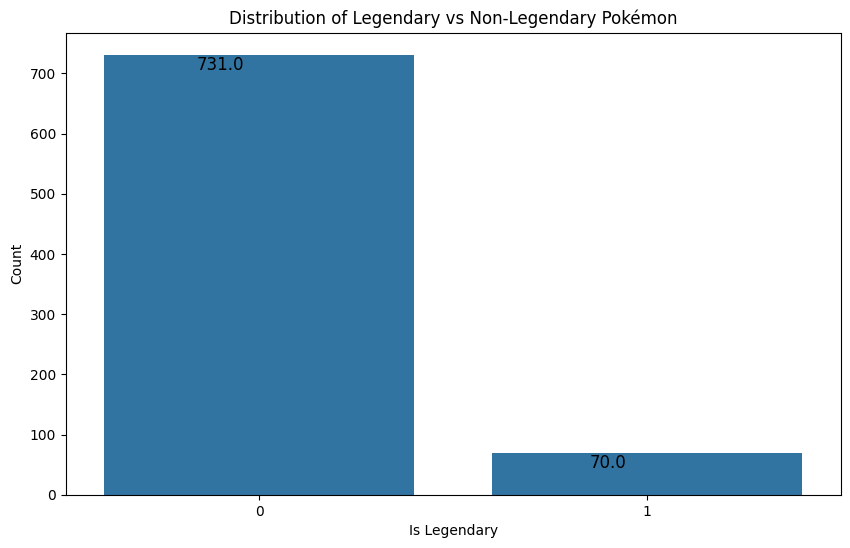

In [268]:
# Visualize the ratio of legendary and non-legendary Pokémon
plt.figure(figsize=(10, 6))
dstrbtn = sns.countplot(x='is_legendary', data=dataset)
for p in dstrbtn.patches:
    dstrbtn.annotate(f'\n{p.get_height()}', (p.get_x() + 0.3, p.get_height()), ha='center', va='center', color='black', size=12)
plt.title('Distribution of Legendary vs Non-Legendary Pokémon')
plt.xlabel('Is Legendary')
plt.ylabel('Count')
plt.show()

In [269]:
# Cleaning the data, for simplicity I'll have the model only look at numeric values
dataset_cleaned = dataset.select_dtypes(exclude=['object']).drop(['pokedex_number', 'percentage_male'], axis=1).dropna()
print(f'Cleaned dataset shape: {dataset_cleaned.shape}')
dataset_cleaned.head()

Cleaned dataset shape: (781, 32)


,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,defense,experience_growth,height_m,hp,sp_attack,sp_defense,speed,weight_kg,generation,is_legendary
0,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,49,1059860,0.7,45,65,65,45,6.9,1,0
1,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,63,1059860,1.0,60,80,80,60,13.0,1,0
2,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,...,123,1059860,2.0,80,122,120,80,100.0,1,0
3,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,43,1059860,0.6,39,60,50,65,8.5,1,0
4,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,...,58,1059860,1.1,58,80,65,80,19.0,1,0


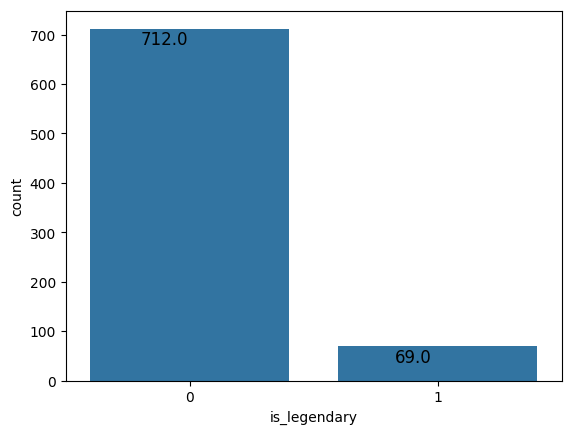

In [270]:
# Check the ratio of legendaries hasn't changed too much
dstrbtn = sns.countplot(x='is_legendary', data=dataset_cleaned)
for p in dstrbtn.patches:
    dstrbtn.annotate(f'\n{p.get_height()}', (p.get_x() + 0.3, p.get_height()), ha='center', va='center', color='black', size=12)
plt.show()

In [271]:
# Split the data into input features (X) and labels (y)
X = dataset_cleaned.iloc[:, :-1]
y = dataset_cleaned.iloc[:, -1]

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X.values)

# Split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=60, stratify=y)


In [199]:
# Dataset classes
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.x_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return len(self.x_data)
    
train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

class TestData(Dataset):
    def __init__(self, X_data):
        self.x_data = X_data

    def __getitem__(self, index):
        return self.x_data[index]
    
    def __len__(self):
        return len(self.x_data)
    
test_data = TestData(torch.FloatTensor(X_test))


In [200]:
# Hyperparameters
HIDDEN_SIZE = 64
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [201]:
# DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [202]:
# Defining the model
class PokePredictor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PokePredictor, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu1(x)
        x = self.batchnorm1(x)
        x = self.l2(x)
        x = self.relu2(x)
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.out(x)
        return x

model = PokePredictor(input_size=X_train.shape[1], hidden_size=HIDDEN_SIZE)
model.to(device)

PokePredictor(
  (l1): Linear(in_features=31, out_features=64, bias=True)
  (relu1): ReLU()
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [203]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [204]:
# Training loop, printing accuracy at each step
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {e:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')


Epoch 001: | Loss: 0.68222 | Acc: 57.471
Epoch 002: | Loss: 0.56559 | Acc: 77.294
Epoch 003: | Loss: 0.50446 | Acc: 83.647
Epoch 004: | Loss: 0.43211 | Acc: 89.941
Epoch 005: | Loss: 0.36377 | Acc: 93.765
Epoch 006: | Loss: 0.30827 | Acc: 94.706
Epoch 007: | Loss: 0.28038 | Acc: 96.706
Epoch 008: | Loss: 0.22311 | Acc: 96.765
Epoch 009: | Loss: 0.20154 | Acc: 98.235
Epoch 010: | Loss: 0.16378 | Acc: 97.353
Epoch 011: | Loss: 0.12314 | Acc: 98.588
Epoch 012: | Loss: 0.15399 | Acc: 96.824
Epoch 013: | Loss: 0.08175 | Acc: 99.824
Epoch 014: | Loss: 0.08415 | Acc: 98.941
Epoch 015: | Loss: 0.05781 | Acc: 99.647
Epoch 016: | Loss: 0.07479 | Acc: 99.118
Epoch 017: | Loss: 0.05316 | Acc: 99.471
Epoch 018: | Loss: 0.04133 | Acc: 99.824
Epoch 019: | Loss: 0.05086 | Acc: 99.294
Epoch 020: | Loss: 0.03331 | Acc: 99.824


In [205]:
# Testing the model 
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [206]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_list)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[235   0]
 [  4  19]]


All 235 Non-legendaries were correctly classified, and only 3 legendaries were incorrectly classified. 

In [207]:
# Computing the accuracy on the test set
accuracy = accuracy_score(y_test, y_pred_list)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9845


Testing the model

Please note the pictures are only for show, the model is only basing its predictions on the numerical components of a pokemon (Stats, height, weight, type advantages, etc)

Pokemon: regigigas
Legendary confidence level: 1.000


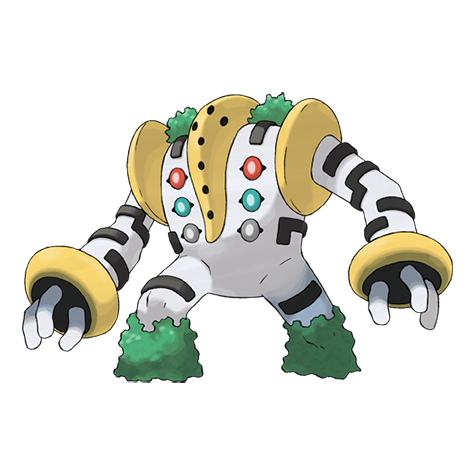

In [265]:
# Prediction for a single Pokemon (randomly chosen)
pokemon = dataset.sample()
pokemon_name = pokemon['name'].values[0].lower()

pokemon = pokemon[dataset_cleaned.columns].values[0][:-1]
pokemon = scaler.transform(pokemon.reshape(1, -1))
pokemon = torch.FloatTensor(pokemon).to(device)

model.eval()
with torch.no_grad():
    y_pred = model(pokemon)
    y_pred = torch.sigmoid(y_pred)

img = Image.open(f'Pokemon Dataset/{pokemon_name}.png')
print(f'Pokemon: {pokemon_name}')
print(f'Legendary confidence level: {y_pred.item():.3f}')
img